In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import os, re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

from tqdm import tqdm



In [2]:
import warnings
warnings.filterwarnings("ignore")

cosine sim for all datapoints

In [3]:
# # Assuming tfidf_matrix and the combined_data dataframe are already defined from the previous steps

# # Compute Cosine Similarity
# cosine_sim = cosine_similarity(tfidf_matrix)

# # Create a DataFrame for the cosine similarity matrix
# cosine_sim_df = pd.DataFrame(cosine_sim, cluster=combined_data['role'], columns=combined_data['role'])

# # Display the cosine similarity matrix
# print("Cosine Similarity Matrix:")
# cosine_sim_df


avg cosine sim between each query (role)

In [4]:
def calculate_average_cosine_sim(tfidf_df: pd.DataFrame):
    roles = pd.unique(tfidf_df['role'])

    # Extracting TF-IDF features for each role
    role_tfidf_matrices = [tfidf_df[tfidf_df['role'] == role].drop('role', axis=1) for role in roles]

    # Initialize a matrix to store average cosine similarities
    average_cosine_sim = pd.DataFrame(cluster=roles, columns=roles, dtype=float)
    
    print([a.shape for a in role_tfidf_matrices])

    for i, role_i in enumerate(roles):
        for j, role_j in enumerate(roles):
            print(role_i,role_j)
            cosine_sim_ij = cosine_similarity(role_tfidf_matrices[i], role_tfidf_matrices[j])
            if i == j:
                # Exclude the diagonal (self-similarities) before averaging
                np.fill_diagonal(cosine_sim_ij, np.nan)
                average = np.nanmean(cosine_sim_ij)
            else:
                average = cosine_sim_ij.mean()
            average_cosine_sim.iloc[i, j] = average
            average_cosine_sim.iloc[j, i] = average  # Symmetric matrix

    return average_cosine_sim

In [27]:
import time

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

def test_clusters_agglomerative(tfidf_matrix, strategy, cluster_range, Z=None):
    """
    Test and plot metrics for agglomerative clustering for up to max_clusters.

    :param tfidf_matrix: TF-IDF matrix of the text data.
    :param strategy: Linkage criterion for Agglomerative Clustering ('ward', 'average', 'complete').
    :param max_clusters: Maximum number of clusters to test (default is 10).
    """
    # Perform Agglomerative Clustering
    if Z is None:
        # Timing the linkage execution
        start_time = time.time()
        if isinstance(tfidf_matrix, np.ndarray):
            Z = linkage(tfidf_matrix, method=strategy)
        else:
            Z = linkage(tfidf_matrix.toarray(), method=strategy)
        end_time = time.time()
        print(f"linkage executed in {(end_time - start_time):.2f} seconds")
        
    # Initialize lists to store metrics
    silhouette_scores_agg = []
    davies_bouldin_scores_agg = []

    for n_clusters in tqdm(cluster_range,total=len(cluster_range)):
        # Extracting labels for n clusters from the dendrogram
        labels = fcluster(Z, n_clusters, criterion='maxclust')
        
        # Silhouette Score
        silhouette_avg = silhouette_score(tfidf_matrix, labels, random_state=123)
        silhouette_scores_agg.append(silhouette_avg)
        
        # Davies-Bouldin Score
        db_score = davies_bouldin_score(tfidf_matrix, labels)
        davies_bouldin_scores_agg.append(db_score)

    # Plotting the metrics
    plt.figure(figsize=(10, 5))

    # Plot Silhouette Scores
    plt.subplot(1, 2, 1)
    plt.plot(cluster_range, silhouette_scores_agg, marker='o')
    plt.title(f'Silhouette Scores vs. Number of Clusters ({strategy})')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)

    # Plot Davies-Bouldin Scores
    plt.subplot(1, 2, 2)
    plt.plot(cluster_range, davies_bouldin_scores_agg, marker='o')
    plt.title(f'Davies-Bouldin Scores vs. Number of Clusters ({strategy})')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies-Bouldin Score')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame.from_dict({'n_clusters':cluster_range, 'silhouette':silhouette_scores_agg, 'davies_bouldin':davies_bouldin_scores_agg}) 

In [6]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html


def get_cluster_labels_agglomerative(tfidf_matrix, strategy, n_clusters, Z=None):
    """
    Perform Agglomerative Clustering on the given TF-IDF matrix, plot the dendrogram,
    and return the cluster labels.

    :param tfidf_matrix: TF-IDF matrix after dimensionality reduction to 25 components.
    :param strategy: Linkage criterion for Agglomerative Clustering.
    :param n_clusters: The number of clusters to form.
    :return: Cluster labels.
    """
    # assert tfidf_matrix.shape[1] == 25  # Ensure we have 25 components

    if Z is None:
        # Timing the linkage execution
        start_time = time.time()
        if isinstance(tfidf_matrix, np.ndarray):
            Z = linkage(tfidf_matrix, method=strategy)
        else:
            Z = linkage(tfidf_matrix.toarray(), method=strategy)
        end_time = time.time()
        print(f"linkage executed in {(end_time - start_time):.2f} seconds")

    # Plotting the dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(
        Z,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=n_clusters,  # show only the last p merged clusters
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,  # to get a distribution impression in truncated branches
    )
    plt.title(f'Dendrogram for Agglomerative Clustering with {strategy} linkage')
    plt.xlabel('Cluster size')
    plt.ylabel('Distance')
    plt.show()

    # Extracting labels for n clusters from the dendrogram
    labels = fcluster(Z, n_clusters, criterion='maxclust')

    silhouette_avg = silhouette_score(tfidf_matrix, labels, random_state=123)
    db_score = davies_bouldin_score(tfidf_matrix, labels)
    
    print(silhouette_avg, db_score)
    print(pd.Series(labels).value_counts())
    
    return labels, silhouette_avg, db_score

In [7]:
def plot_and_save_dendrograms(tfidf_matrix, strategy, cluster_range, save_dir, Z=None):
    """
    Perform linkage once, loop through a range of cluster numbers, and save dendrogram plots with figsize proportional to n_clusters.

    :param tfidf_matrix: TF-IDF matrix after dimensionality reduction.
    :param strategy: Linkage criterion for Agglomerative Clustering.
    :param cluster_range: Range of cluster numbers to plot dendrograms for.
    :param save_dir: Directory to save the dendrogram plots.
    """
    # Create the directory if it does not exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Perform linkage
    if Z is None:
        # Timing the linkage execution
        start_time = time.time()
        if isinstance(tfidf_matrix, np.ndarray):
            Z = linkage(tfidf_matrix, method=strategy)
        else:
            Z = linkage(tfidf_matrix.toarray(), method=strategy)
        end_time = time.time()
        print(f"linkage executed in {(end_time - start_time):.2f} seconds")

    for n_clusters in tqdm(cluster_range, total=len(cluster_range)):
        # Adjusting figure size based on the number of clusters
        fig_width = max(10, 1.21*(n_clusters / 3))
        fig_height = max(7, 1.21*(n_clusters / 4))

        plt.figure(figsize=(fig_width, fig_height))
        dendrogram(
            Z,
            truncate_mode='lastp',  # to improve readability
            p=n_clusters,  # show only the last p merged clusters
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,
        )
        plt.title(f'Dendrogram for {n_clusters} Clusters with {strategy} Linkage')
        plt.xlabel('Cluster size')
        plt.ylabel('Distance')

        # Save the plot
        plt.savefig(f'{save_dir}/dendrogram_{n_clusters}_clusters.png', dpi=300)
        plt.close()


In [8]:
def remove_duplicates(df:pd.DataFrame, exclude=None):
    subset_columns = ['Job Title', 'Company Name', 'Location', 'Salary Estimate', 'Rating', 'Job Description']
    if exclude:
        if isinstance(exclude, list):
            subset_columns = [a for a in subset_columns if a not in exclude]
        else:
            subset_columns.remove(exclude)
    
    df.sort_values(subset_columns, inplace=True)

    df['Duplicate Count'] = df.groupby(subset_columns)['Job Title'].transform('count')
    print(df['Duplicate Count'].value_counts())
    df.drop_duplicates(subset=subset_columns, inplace=True, keep='last')
    df.reset_index(drop=True,inplace=True)
    

In [9]:

df_business_analyst = pd.read_csv('combined scraper results/business analyst clean.csv')
df_data_analyst = pd.read_csv('combined scraper results/data analyst clean.csv')
df_data_engineer = pd.read_csv('combined scraper results/data engineer clean.csv')
df_data_scientist = pd.read_csv('combined scraper results/data scientist clean.csv')

# Combine data for TF-IDF analysis
combined_data = pd.concat([
    df_business_analyst.assign(role="Business Analyst"),
    df_data_analyst.assign(role="Data Analyst"),
    df_data_scientist.assign(role="Data Scientist"),
    df_data_engineer.assign(role="Data Engineer"),
])
# print(combined_data.role.value_counts())
# combined_data
remove_duplicates(combined_data, exclude=['Location','Salary Estimate']) # sometimes salary is location-dependent. we are only analyzing job descriptions so this is fine.
print(combined_data.role.value_counts())

# Job Title,Company Name,Location,Salary Estimate,Rating,Job Description,Founded,Industry,Revenue,Sector,Size,Type,Easy Apply,Duplicate Count,
# Job Title clean,Salary Type,min_salary,max_salary,job_description_cleaned,Years Experience

combined_data

Duplicate Count
1.0     15855
2.0      7490
3.0       513
4.0       288
6.0       168
5.0       145
10.0      120
50.0      100
7.0        98
97.0       97
31.0       93
42.0       84
8.0        80
26.0       78
37.0       74
24.0       72
71.0       71
33.0       66
16.0       64
9.0        63
60.0       60
15.0       60
12.0       48
47.0       47
40.0       40
39.0       39
17.0       34
11.0       33
30.0       30
29.0       29
28.0       28
27.0       27
13.0       26
22.0       22
20.0       20
19.0       19
14.0       14
Name: count, dtype: int64
role
Data Analyst        8702
Business Analyst    6511
Data Scientist      4626
Data Engineer       2217
Name: count, dtype: int64


,Job Title,Company Name,Location,Salary Estimate,Rating,Job Description,Founded,Industry,Revenue,Sector,...,Easy Apply,Duplicate Count,Salary Type,min_salary,max_salary,State,job_description_cleaned,Job Title clean,Years Experience,role
0,#11598 - Data Collection Moderator,Qualitest,"Mountain View, CA",50-70,3.5,Q Analysts - A Qualitest Company is looking fo...,1997.0,Information Technology Support Services,NaN,Information Technology,...,True,1.0,Annual (K),50.0,70.0,CA,q analyst a qualitest company is looking for a...,data collection moderator,2+,Data Scientist
1,#11885 - Data Collection Technician,Qualitest,"Burlingame, CA",20.00-22.00,3.5,"Q Analysts, a Qualitest Company, is looking fo...",1997.0,Information Technology Support Services,NaN,Information Technology,...,True,1.0,Per Hour,20.0,22.0,CA,q analyst a qualitest company is looking for a...,data collection technician,2+,Data Scientist
2,(2) Sr Business Analyst/s,RiseIT Solutions,"Des Moines, IA",63.00,3.7,Title: (2) Sr Business Analyst/s\nLocation: De...,NaN,Enterprise Software & Network Solutions,NaN,Information Technology,...,False,2.0,Per Hour,63.0,63.0,IA,title senior business analyst s location de mo...,senior business analyst s,NaN,Data Analyst
3,"(Associate) Director, Manufacturing Operations","Novavax, Inc.","Gaithersburg, MD",109-159,3.3,(Nasdaq:NVAX) is a late-stage biotechnology co...,1987.0,Biotech & Pharmaceuticals,$100 to $500 million (USD),Pharmaceutical & Biotechnology,...,False,1.0,Annual (K),109.0,159.0,MD,nasdaq nvax is a late stage biotechnology comp...,director manufacturing operation,7-10,Business Analyst
4,(Bid) Pricing Analyst,Daikin Comfort Technologies,"Denver, CO",67-93,3.3,Overview:\n\n(Bid) Pricing Analyst -Remote\n\n...,1924.0,Machinery Manufacturing,NaN,Manufacturing,...,False,1.0,Annual (K),67.0,93.0,CO,overview bid pricing analyst remote about moti...,pricing analyst,NaN,Data Analyst
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22051,senior data engineer,Capgemini,"Saint Louis, MO",100-134,3.7,JOB DESCRIPTION\n\nHaving experience with AWS ...,1967.0,Enterprise Software & Network Solutions,$10+ billion (USD),Information Technology,...,False,1.0,Annual (K),100.0,134.0,MO,job description having experience with aws ser...,senior data engineer,7-10,Data Engineer
22052,"senior performance measures analyst , HR Share...",Starbucks,"Seattle, WA",78-133,3.7,Final compensation range is determined by cand...,1971.0,Restaurants & Cafes,$10+ billion (USD),Restaurants & Food Service,...,False,1.0,Annual (K),78.0,133.0,WA,final compensation range is determined by cand...,senior performance measure analyst hr shared s...,5+,Data Analyst
22053,systems Analyst with to fraud mitigation on w2,Formac Inc,"Houston, TX",34.00-48.00,4.2,Systems analyst on w2\n\nHybrid Houston TX\n\n...,2013.0,Information Technology Support Services,NaN,Information Technology,...,True,1.0,Per Hour,34.0,48.0,TX,system analyst on hybrid houston tx hr on work...,system analyst to fraud mitigation on,5,Business Analyst
22054,vCIO,"CITOC, Inc.","Houston, TX",80-100,3.2,Primary Role and Responsibilities\n\nBusiness ...,NaN,-1,$1 to $5 million (USD),NaN,...,True,1.0,Annual (K),80.0,100.0,TX,primary role and responsibility business strat...,vcio,3,Business Analyst


In [30]:

# def convert_matrix_to_df(mat, feature_names):
#     if not isinstance(mat, np.ndarray):
#         mat = mat.toarray()
#     df = pd.DataFrame(mat, columns=feature_names)
#     return df


def filter_top_n_features(count_mat, vectorizer, n):
    # Efficiently summing up the counts and getting the top n features
    sum_words = np.array(count_mat.sum(axis=0)).ravel()
    top_n_indices = np.argsort(sum_words)[::-1][:n]
    feature_names = np.array(vectorizer.get_feature_names_out())[top_n_indices]
    filtered_count_mat = count_mat[:, top_n_indices]
    return filtered_count_mat, feature_names

def get_count_and_tfidf_dfs(df, column, count_vectorizer, top_n=None):
    print(column, count_vectorizer.ngram_range)
    count_mat = count_vectorizer.fit_transform(df[column].fillna(''))
    print(count_mat.shape)
    
    if top_n is not None and top_n < count_mat.shape[1]:
        print("Original count matrix shape:", count_mat.shape)
        count_mat, feature_names = filter_top_n_features(count_mat, count_vectorizer, top_n)
        print("Filtered count matrix shape:", count_mat.shape)
    else:
        feature_names = count_vectorizer.get_feature_names_out()
    
    tfidf_transformer = TfidfTransformer()
    tfidf_mat = tfidf_transformer.fit_transform(count_mat)

    return count_mat, tfidf_mat, feature_names

def compute_cluster_means(sparse_mat, cluster_assignments):
    unique_clusters = np.unique(cluster_assignments)
    means = {}

    for cluster in unique_clusters:
        cluster_rows = sparse_mat[cluster_assignments == cluster]
        cluster_mean = np.array(cluster_rows.mean(axis=0)).flatten()
        means[cluster] = cluster_mean
    return means

def search_keywords(feats, patterns, n, regex):
    ids = []
    for i, f in enumerate(feats):
        if regex:
            if any(regex.search(f) for regex in patterns):
                ids.append(i)
        else:
            if any(keyword in f for keyword in patterns):
                ids.append(i)
        if len(ids) == n:
            break
    return np.array(ids)

def get_feats_helper(feats, vals, ids, n):
    if len(ids) == 0:
        feats_ = ['no keywords found']+list(range(n-1))
        vals_ = [0]*n
    else:
        feats_ = feats[ids]
        vals_ = vals[ids]
    return feats_, vals_

def plot_and_save_top_keywords(count_mat, tfidf_mat, feature_names, column, top_n_for_graph, top_n_for_sheet, save_dir, cluster_assignments=None, keywords=None, regex=True):
    # Add cluster assignments if provided
    if cluster_assignments is None:
        cluster_assignments = list(np.zeros((count_mat.shape[0],), dtype=int))

    tfidf_means = compute_cluster_means(tfidf_mat, cluster_assignments)
    count_means = compute_cluster_means(count_mat, cluster_assignments)
    
    if keywords is not None and regex:
        regex_patterns = [re.compile(r'\b' + re.escape(kw) + r'\b') for kw in keywords]
            
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    dataframes = []
        
    # Visualizing the top top_n_for_graph keywords for each role (and cluster if applicable)
    for cluster in tfidf_means:
        size = (cluster_assignments == cluster).sum()
        plt.figure(figsize=(12, 8*(top_n_for_graph/10)))
        plt.tight_layout()

        top_tfidf_indices = np.argsort(-tfidf_means[cluster])
        top_tfidf_values = -np.sort(-tfidf_means[cluster])
        top_tfidf_features = feature_names[top_tfidf_indices].flatten()
        top_count_indices = np.argsort(-count_means[cluster])
        top_count_values = -np.sort(-count_means[cluster])
        top_count_features = feature_names[top_count_indices].flatten()

        if keywords is not None:
            ids = search_keywords(top_tfidf_features, regex_patterns if regex else keywords, top_n_for_graph, regex)
            top_tfidf_features_, top_tfidf_values_ = get_feats_helper(top_tfidf_features, top_tfidf_values, ids, top_n_for_graph)
            ids = search_keywords(top_count_features, regex_patterns if regex else keywords, top_n_for_graph, regex)
            top_count_features_, top_count_values_ = get_feats_helper(top_count_features, top_count_values, ids, top_n_for_graph)
        else:
            top_tfidf_features_, top_tfidf_values_ = top_tfidf_features, top_tfidf_values
            top_count_features_, top_count_values_ = top_count_features, top_count_values
            
        # Plotting TF-IDF
        ax1 = plt.subplot(2, 1, 1)
        sns.barplot(x=top_tfidf_values_[:top_n_for_graph], y=top_tfidf_features_[:top_n_for_graph], ax=ax1)
        ax1.set_xlabel('TF-IDF Score')
        ax1.set_ylabel('Tokens')
        ax1.set_yticklabels(top_tfidf_features_[:top_n_for_graph], rotation=0)

        # Plotting Count Vectorizer
        ax2 = plt.subplot(2, 1, 2)
        sns.barplot(x=top_count_values_[:top_n_for_graph], y=top_count_features_[:top_n_for_graph], ax=ax2)
        ax2.set_xlabel('Word Frequency')
        ax2.set_ylabel('Tokens')
        ax2.set_yticklabels(top_count_features_[:top_n_for_graph], rotation=0)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.92,left=0.5)  # Reserve 50% of the figure's width for labels
        
        if keywords is not None:
            ids = search_keywords(top_tfidf_features, regex_patterns if regex else keywords, top_n_for_sheet, regex)
            top_tfidf_features_, top_tfidf_values_ = get_feats_helper(top_tfidf_features, top_tfidf_values, ids, top_n_for_sheet)
            ids = search_keywords(top_count_features, regex_patterns if regex else keywords, top_n_for_sheet, regex)
            top_count_features_, top_count_values_ = get_feats_helper(top_count_features, top_count_values, ids, top_n_for_sheet)
        else:
            top_tfidf_features_, top_tfidf_values_ = top_tfidf_features, top_tfidf_values
            top_count_features_, top_count_values_ = top_count_features, top_count_values

        merged = pd.DataFrame({'token_tfidf': top_tfidf_features_[:top_n_for_sheet], 'tfidf': top_tfidf_values_[:top_n_for_sheet],
                            'token_wordfreq': top_count_features_[:top_n_for_sheet], 'wordfreq': top_count_values_[:top_n_for_sheet]})
        merged['cluster_assignment'] = cluster
        merged['cluster_size'] = size
        dataframes.append(merged)

        # Save the plot
        if len(set(cluster_assignments)) != 1:
            plt.suptitle(f"{column}: Comparison of Top {top_n_for_graph} Keywords for Cluster {cluster} ({size} docs)\n")
            plt.savefig(f'{save_dir}/top_{top_n_for_graph}_keywords_cluster_{cluster}.png', dpi=300)
        else:
            plt.suptitle(f"{column}: Comparison of Top {top_n_for_graph} Keywords ({size} docs)")
            plt.savefig(f'{save_dir}/top_{top_n_for_graph}_keywords.png', dpi=300)
        plt.close()
        
    sheet = pd.concat(dataframes, ignore_index=True)
    sheet = sheet[['cluster_assignment', 'cluster_size', 'token_wordfreq', 'wordfreq', 'token_tfidf', 'tfidf']]
    if len(set(cluster_assignments)) != 1:
        sheet.to_csv(f'{save_dir}/top_{top_n_for_sheet}_keywords_per_cluster.csv', index=False)
    else:
        sheet.drop('cluster_assignment',axis=1).to_csv(f'{save_dir}/top_{top_n_for_sheet}_keywords.csv', index=False)

In [11]:
ng = (1,2)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(ngram_range=ng)
tfidf_matrix = vectorizer.fit_transform(combined_data['job_description_cleaned'])
# Create a DataFrame with TF-IDF scores
feature_names = vectorizer.get_feature_names_out()

# tfidf_df = convert_matrix_to_df(tfidf_matrix, vectorizer.get_feature_names_out())
# tfidf_df['role'] = combined_data['role'].values


print(tfidf_matrix.shape)


(22056, 1376965)


In [12]:
# def view_least_freq(data, vectorizer):
#     mat = vectorizer.fit_transform(data.fillna(''))

#     df = convert_matrix_to_df(mat, vectorizer.get_feature_names_out())
#     df.drop('role', axis=1,inplace=True)

#     doc_freq = (df > 0).sum(axis=0)
#     sorted_doc_freq = doc_freq.sort_values()
#     return sorted_doc_freq

# test = view_least_freq(combined_data['job_description_cleaned'], CountVectorizer(min_df=1, max_df=1.0, stop_words='english'))
# test = test.reset_index()
# test.columns = ['token','count']
# test

In [13]:
# cos_sims = calculate_average_cosine_sim(tfidf_df)
# cos_sims

                        Data Scientist  Data Analyst    Business Analyst	Data Engineer
    Data Scientist	    0.099276	    0.077849	    0.073179            0.095237
    Data Analyst	    0.077849	    0.088754	    0.085288	        0.085110
    Business Analyst    0.073179	    0.085288	    0.088391	        0.078052
    Data Engineer	    0.095237	    0.085110	    0.078052	        0.119045

test decomposition with TruncatedSVD

In [14]:
# tfidf_matrix_decomp

    array([[ 3.22054530e-01, -2.03002929e-01, -1.26119411e-01, ...,
            1.90283091e-04, -4.05367395e-04,  2.26488762e-03],
          [ 1.88963908e-01, -4.33658327e-02,  5.47991193e-02, ...,
            2.78098324e-05,  1.89455735e-03,  4.82531307e-04],
          [ 2.08284491e-01, -1.78483054e-02,  3.75703515e-02, ...,
            3.11541523e-04,  1.08826508e-03,  1.15513528e-03],
          ...,
          [ 3.50560087e-01,  1.09246448e-01, -3.36769317e-02, ...,
            5.13353633e-03, -2.22408588e-03,  4.28153272e-03],
          [ 3.77481000e-01,  2.07483588e-01, -3.41345912e-04, ...,
            -2.44866418e-03, -7.30164871e-04, -6.23416347e-03],
          [ 2.35961646e-01,  5.48711234e-02,  1.16743075e-01, ...,
            1.03943299e-03, -1.02164394e-03,  5.03574293e-04]])

In [15]:
# svd.explained_variance_ratio_

       array([7.29829265e-03, 1.40313793e-02, 9.06467749e-03, ...,
              9.09887736e-06, 9.08602871e-06, 9.07868477e-06])

In [16]:
import pickle
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

max_components_save = 1000  # Adjust as needed
if os.path.exists(f'decomposition ngrams {ng[0]}-{ng[1]}/tfidf_matrix_svd_{max_components_save}.pkl') and os.path.exists(f'decomposition ngrams {ng[0]}-{ng[1]}/svd_{max_components_save}.pkl'):
    # To load the matrix from the file later
    with open(f'decomposition ngrams {ng[0]}-{ng[1]}/tfidf_matrix_svd_{max_components_save}.pkl', 'rb') as file:
        tfidf_matrix_decomp = pickle.load(file)
        print(tfidf_matrix_decomp.shape)
    with open(f'decomposition ngrams {ng[0]}-{ng[1]}/svd_{max_components_save}.pkl', 'rb') as file:
        svd = pickle.load(file)
        cumulative_explained_variance_ratio = np.cumsum(svd.explained_variance_ratio_)
        print(cumulative_explained_variance_ratio.shape)
else:
    os.mkdir(f'decomposition ngrams {ng[0]}-{ng[1]}')
    
    svd = TruncatedSVD(n_components=max_components_save, random_state=42)
    svd.fit(tfidf_matrix)

    # Cumulative explained variance ratio
    cumulative_explained_variance_ratio = np.cumsum(svd.explained_variance_ratio_)

    tfidf_matrix_decomp = svd.transform(tfidf_matrix)
    print(tfidf_matrix_decomp.shape)

    # Save the decomposed matrix to a file
    with open(f'decomposition ngrams {ng[0]}-{ng[1]}/tfidf_matrix_svd_{max_components_save}.pkl', 'wb') as file:
        pickle.dump(tfidf_matrix_decomp, file)
    with open(f'decomposition ngrams {ng[0]}-{ng[1]}/svd_{max_components_save}.pkl', 'wb') as file:
        pickle.dump(svd, file)
# print(svd.explained_variance_ratio_)
# print(tfidf_matrix_decomp)

(22056, 1000)
(1000,)


(22056, 400)


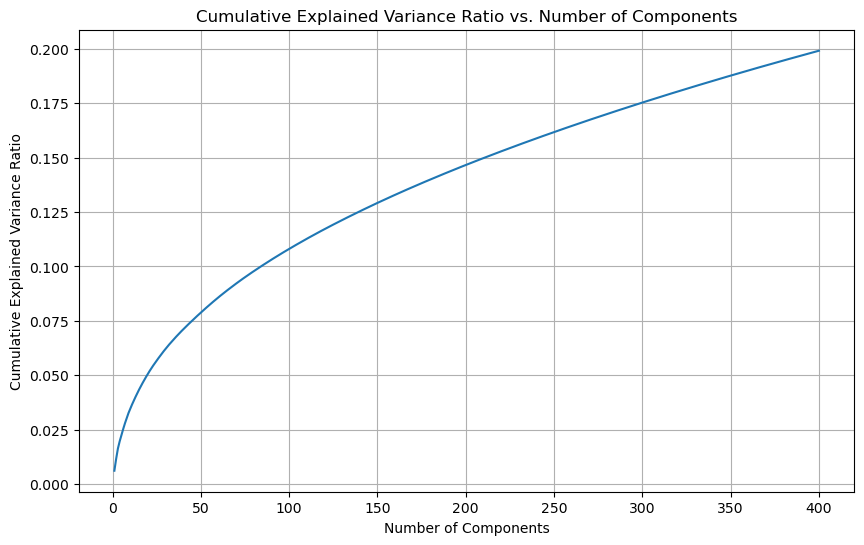

In [17]:
max_components = 400
tfidf_matrix_decomp_small = tfidf_matrix_decomp[:,:max_components]
print(tfidf_matrix_decomp_small.shape)
# 
# Plotting the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), cumulative_explained_variance_ratio[:max_components])
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [18]:
tfidf_matrix_decomp_small.shape

(22056, 400)

In [19]:
print(pd.DataFrame(pd.Series(np.ravel(tfidf_matrix_decomp_small)).describe()).drop('count').T)

       mean       std       min       25%       50%       75%       max
0  0.000775  0.026061 -0.449653 -0.009066 -0.000044  0.008975  0.687126


<Axes: ylabel='Count'>

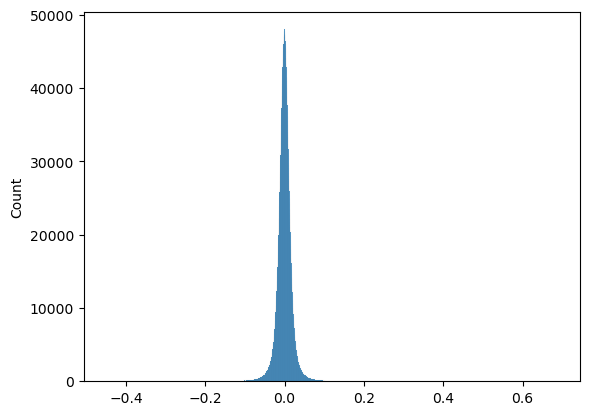

In [20]:
sns.histplot(np.ravel(tfidf_matrix_decomp_small))

# Agglomerative clustering

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

single, complete, average, ward

In [21]:
max_clusters = 30
interval = 1

cluster_range = list(range(2, max_clusters + 1, interval))
# cluster_range = list(range(20, 80 + 1, 10))
# cluster_range_2 = [5,10,15] + list(range(20, 80 + 1, 10))
print(cluster_range)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [22]:
from scipy.cluster.hierarchy import linkage
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import normalize

def create_linkage_matrix(document_vectors, strategy, norm=None):
    """
    Create a linkage matrix from document vectors using the specified strategy.
    
    :param document_vectors: Numpy array of document vectors.
    :param strategy: Linkage criterion for Agglomerative Clustering.
    :return: Linkage matrix Z.
""" 
    if norm is not None:
        document_vectors = normalize(document_vectors, norm=norm)
    Z = linkage(document_vectors, method=strategy)
    return Z, document_vectors


In [23]:
# Z_single = linkage(tfidf_matrix_decomp_small, method='single')
# test_clusters_agglomerative(tfidf_matrix_decomp_small, 'single', cluster_range, Z_single)

In [24]:
# Z_complete = linkage(tfidf_matrix_decomp_small, method='complete')
# test_clusters_agglomerative(tfidf_matrix_decomp_small, 'complete', cluster_range, Z_complete)

In [25]:
# Z_average = linkage(tfidf_matrix_decomp_small, method='average')
# test_clusters_agglomerative(tfidf_matrix_decomp_small, 'average', cluster_range, Z_average)

l2


100%|██████████| 29/29 [07:06<00:00, 14.72s/it]


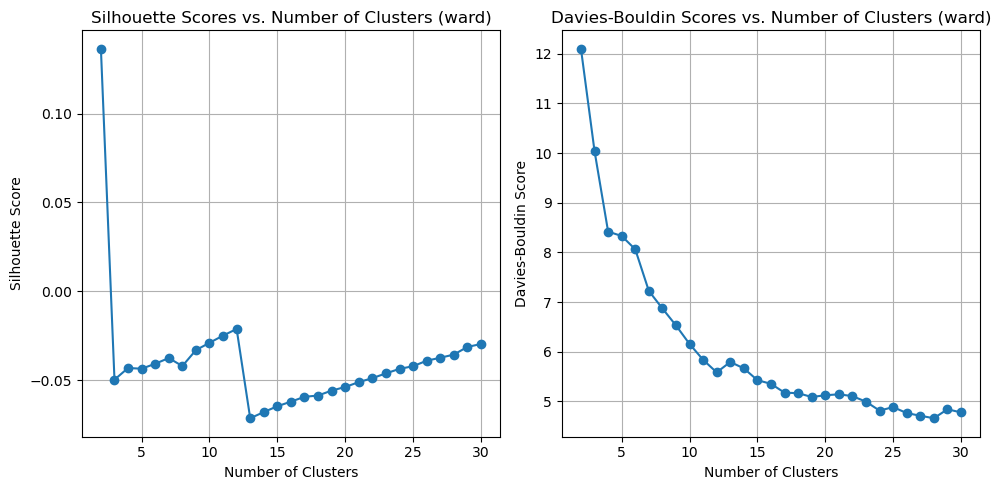

In [28]:
for norm in ['l2']: # 'l1','max',None
    print(norm)
    Z_ward_test, tfidf_matrix_decomp_small_norm = create_linkage_matrix(tfidf_matrix_decomp_small, strategy='ward', norm=norm)
    d = test_clusters_agglomerative(tfidf_matrix_decomp_small, 'ward', cluster_range, Z_ward_test)
    d.to_csv(os.path.join(f'scores vs n_clusters - norm {str(norm or "None")}',f'ngrams {ng[0]}-{ng[1]}.csv'),index=False)

l1


       mean       std       min       25%       50%       75%       max
0  0.000146  0.004668 -0.094084 -0.001763 -0.000009  0.001748  0.148258


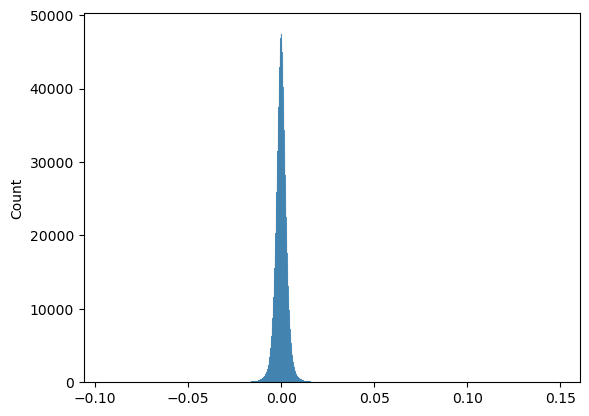

100%|██████████| 29/29 [08:28<00:00, 17.53s/it]


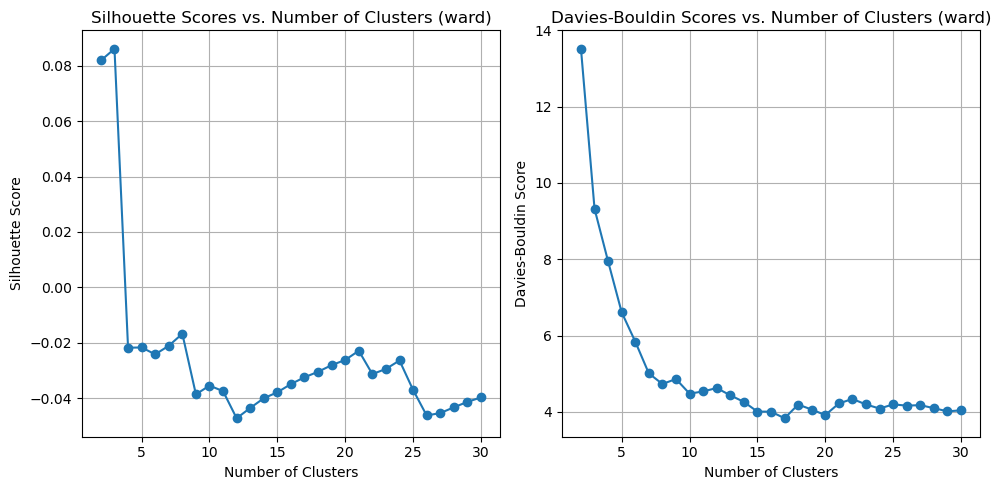

l2
       mean       std       min       25%       50%       75%       max
0  0.001538  0.049976 -0.570118 -0.019386 -0.000091  0.019206  0.903649


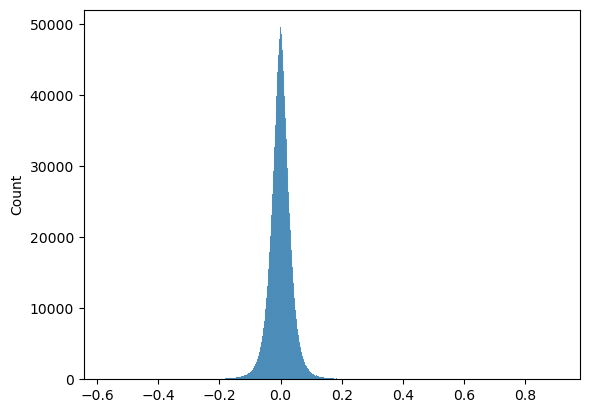

100%|██████████| 29/29 [07:17<00:00, 15.10s/it]


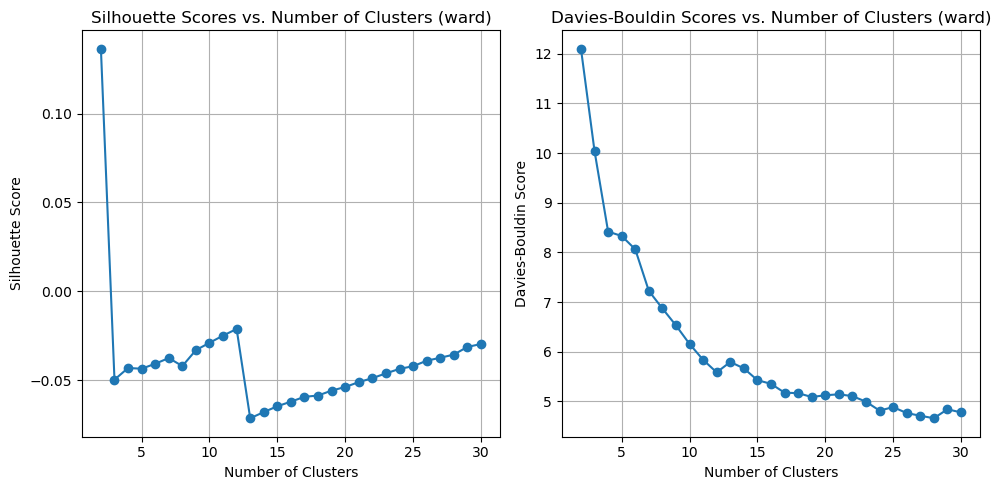

max
       mean      std  min       25%       50%       75%  max
0  0.002607  0.08783 -1.0 -0.030539 -0.000144  0.030237  1.0


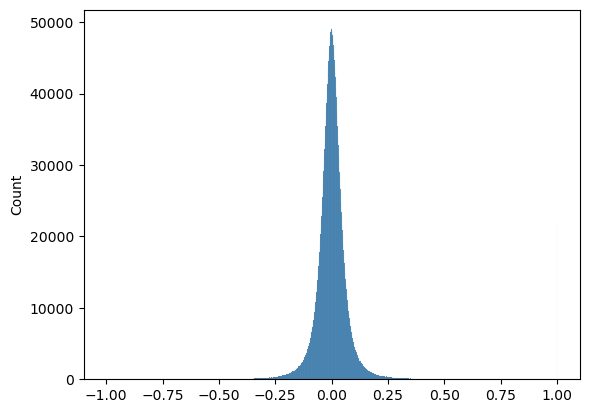

100%|██████████| 29/29 [08:32<00:00, 17.67s/it]


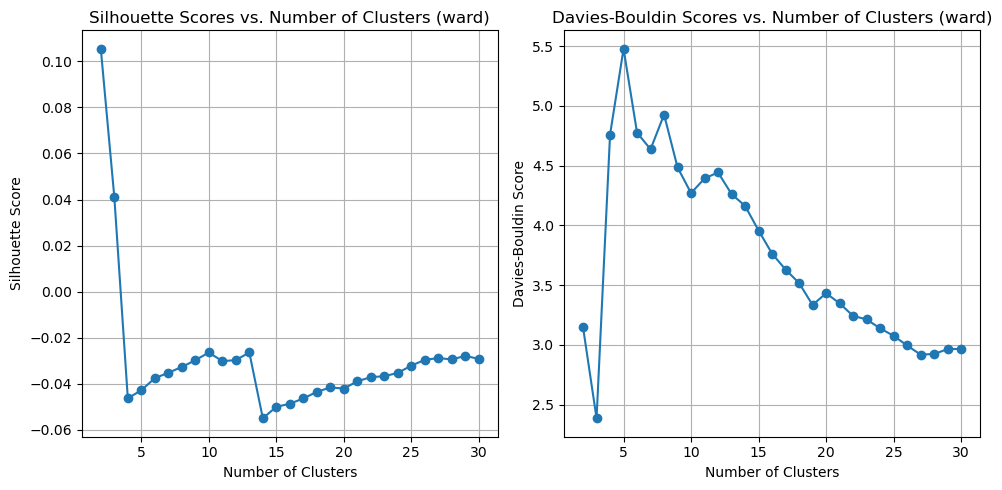

None
       mean       std       min       25%       50%       75%       max
0  0.000775  0.026061 -0.449653 -0.009066 -0.000044  0.008975  0.687126


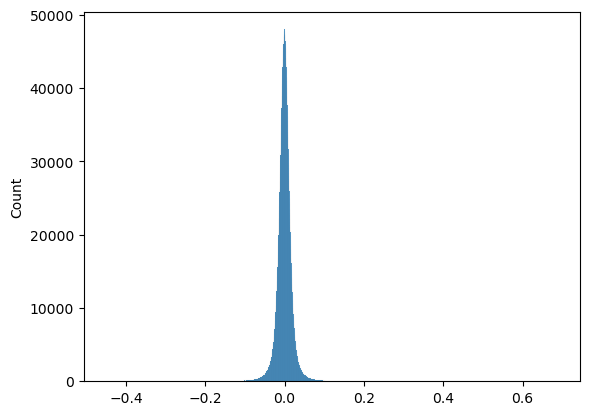

100%|██████████| 29/29 [08:55<00:00, 18.47s/it]


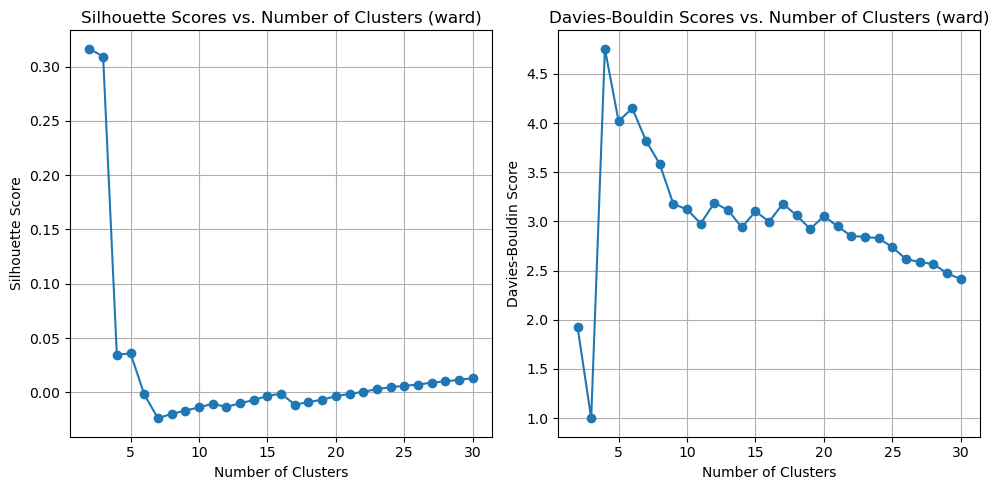

In [26]:
for norm in ['l1','l2','max',None]:
    print(norm)
    Z_ward_test, tfidf_matrix_decomp_small_norm = create_linkage_matrix(tfidf_matrix_decomp_small, strategy='ward', norm=norm)
    print(pd.DataFrame(pd.Series(np.ravel(tfidf_matrix_decomp_small_norm)).describe()).drop('count').T)
    sns.histplot(np.ravel(tfidf_matrix_decomp_small_norm))
    plt.show()
    test_clusters_agglomerative(tfidf_matrix_decomp_small, 'ward', cluster_range, Z_ward_test)

In [31]:
Z_ward, tfidf_matrix_decomp_small = create_linkage_matrix(tfidf_matrix_decomp_small, 'ward', 'l2')

100%|██████████| 29/29 [06:57<00:00, 14.39s/it]


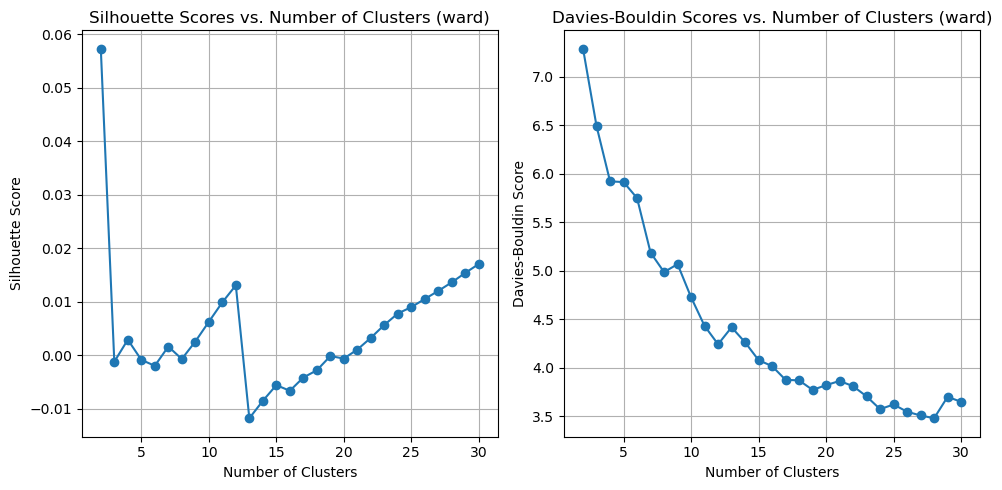

In [ ]:
# Z_ward = linkage(tfidf_matrix_decomp_small, method='ward')
test_clusters_agglomerative(tfidf_matrix_decomp_small, 'ward', cluster_range, Z_ward)

In [ ]:
# test_clusters_agglomerative(tfidf_matrix_decomp_small, 'ward', list(range(2, 100 + 1, 1)), Z_ward)

In [ ]:
# cluster_range_2 = [5,10,15,20,25,30,35,40,45,50,55]
cluster_range_2 = cluster_range

# for strategy, z in zip(['single','complete','average','ward'], [Z_single, Z_complete, Z_average, Z_ward]):
# for strategy, z in zip(['single'], [Z_single]):
# for strategy, z in zip(['complete','average','ward'], [Z_complete, Z_average, Z_ward]):
for strategy, z in zip(['ward'], [Z_ward]):
    # print(strategy, Z)
    plot_and_save_dendrograms(tfidf_matrix_decomp_small, strategy, cluster_range_2, save_dir=os.path.join(f'decomposition ngrams {ng[0]}-{ng[1]}',f'linkage l2 {max_components} components',f'denograms_{strategy}'), Z=z)

100%|██████████| 29/29 [07:10<00:00, 14.83s/it]


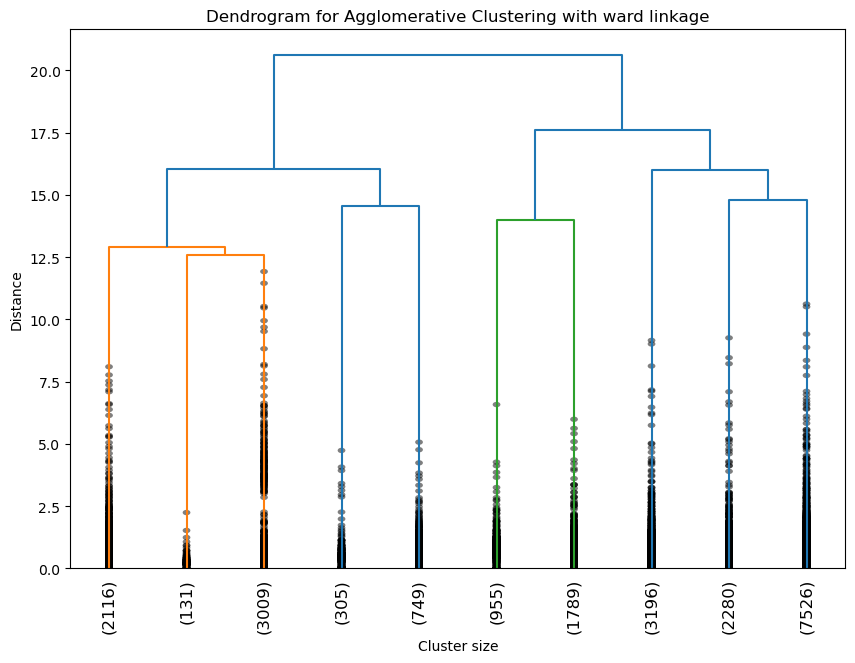

0.006247870915465483 4.726411612142671
10    7526
8     3196
3     3009
9     2280
1     2116
7     1789
6      955
5      749
4      305
2      131
Name: count, dtype: int64


In [32]:
labels, silhouette_avg, db_score = get_cluster_labels_agglomerative(tfidf_matrix_decomp_small, 'ward', 10, Z_ward)

In [25]:
labels

array([6, 2, 6, ..., 7, 4, 6], dtype=int32)

In [26]:
# Job Title,Company Name,Location,Salary Estimate,Rating,Job Description,Founded,Industry,Revenue,Sector,Size,Type,Easy Apply,Duplicate Count,
# Job Title clean,Salary Type,min_salary,max_salary,job_description_cleaned,Years Experience

## filter stopwords

In [27]:

# from nltk.corpus import stopwords as nltk_stopwords
# from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words

# # Counting the number of stopwords in each set
# nltk_stopwords = set(nltk_stopwords.words('english'))
# sklearn_stopwords = set(sklearn_stop_words)

# nltk_stopwords_count = len(nltk_stopwords)
# sklearn_stopwords_count = len(sklearn_stopwords)

# stopword_sets = dict()
# stopword_sets['no'] = None
# stopword_sets['nltk'] = list(nltk_stopwords)
# stopword_sets['sklearn'] = list(sklearn_stopwords)
# stopword_sets['nltk sklearn union'] = list(nltk_stopwords.union(sklearn_stopwords))
# stopword_sets['nltk sklearn intersect'] = list(nltk_stopwords.intersection(sklearn_stopwords))


In [28]:
# for sw in stopword_sets.keys():
#     if sw != 'no':
#         continue
#     selected_stopwords = stopword_sets[sw]
    
#     for column in ['job_description_cleaned']:
#         for i in [1,2,3,4,5]:
#             ii = (i,i)
#             count_mat, tfidf_mat, feature_names = get_count_and_tfidf_dfs(combined_data, column, CountVectorizer(ngram_range=ii, stop_words=selected_stopwords))
                
#             save_dir = os.path.join('keywords stopwords test',f'keywords ngrams {ng[0]}-{ng[1]} {len(set(labels))} clusters {sw} stopwords', f'{column}_{len(set(labels))}_{ii[0]}-{ii[1]}')
#             plot_and_save_top_keywords(count_mat, tfidf_mat, feature_names, column, 10, 100, save_dir)
#             plot_and_save_top_keywords(count_mat, tfidf_mat, feature_names, column, 10, 100, save_dir, labels)

## filter with specified vocab

In [33]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

vocab = {
 'ai', 'artificial intelligence', 'aws', 'apache', 'hadoop', 'spark', 'business intelligence','bi','architecture', 'cleaning','processing','interpretation', 'mining', 'modeling', 
 'visualization', 'warehousing', 'database', 'management', 'etl', 'excel','vba', 'google', 'analyze', 'analysis', 'data analysis','java', 'jupyter', 'kafka', 'machine learning', 'ml', 'deep learning',
 'power bi', 'project management', 'python', 'pytorch', 'r', 'redshift', 'reporting', 'sas','spss', 'scala', 'scikit-learn', 'sql', 'nosql',
 'statistical','statistics',  'tableau','looker', 'tensorflow',
 'plotly','linux','oracle','git','dashboard','c#','c++','matlab','regression','classification','nlp','natural language','computer vision',
 'bachelor','master','phd','computer science','computer engineering','data engineering','mathematics','data science','data analytics','operations','economics','consulting','mba',
 'numpy','matplotlib','scipy','seaborn',
 'javascript','typescript', 'swift', 'ruby', 'rust', 'go', 'net', 'php', 'html', 'dart','apex', 'shell'
}
vocab = set([wordnet_lemmatizer.lemmatize(word) for word in vocab])

In [34]:
for column in ['job_description_cleaned']:
    for i in [1,2,3,4,5]:
        ii = (i,i)
        count_mat, tfidf_mat, feature_names = get_count_and_tfidf_dfs(combined_data, column, CountVectorizer(ngram_range=ii))
            
        save_dir = os.path.join('keywords vocab l2 test regex false',f'keywords ngrams {ng[0]}-{ng[1]} {len(set(labels))} clusters', f'{column}_{len(set(labels))}_{ii[0]}-{ii[1]}')
        plot_and_save_top_keywords(count_mat, tfidf_mat, feature_names, column, 10, 100, save_dir, keywords=vocab, regex=False)
        plot_and_save_top_keywords(count_mat, tfidf_mat, feature_names, column, 10, 100, save_dir, labels, keywords=vocab, regex=False)

job_description_cleaned (1, 1)
(22056, 52449)
job_description_cleaned (2, 2)
(22056, 1324516)
job_description_cleaned (3, 3)
(22056, 4379123)
job_description_cleaned (4, 4)
(22056, 6909497)
job_description_cleaned (5, 5)
(22056, 8204152)


In [33]:
for column in ['Job Title clean','Company Name','Industry','Revenue','Sector','Size','Type','State']:
    for i in [1]:
        ii = (i,i)
        count_mat, tfidf_mat, feature_names = get_count_and_tfidf_dfs(combined_data, column, CountVectorizer(ngram_range=ii, tokenizer=lambda x: [x], lowercase=False))

        save_dir = os.path.join('keywords vocab l2 test regex true',f'keywords ngrams {ng[0]}-{ng[1]} {len(set(labels))} clusters', f'{column}_whole_{len(set(labels))}_{ii[0]}-{ii[1]}')
        plot_and_save_top_keywords(count_mat, tfidf_mat, feature_names, column, 10, 100, save_dir)
        plot_and_save_top_keywords(count_mat, tfidf_mat, feature_names, column, 10, 100, save_dir, labels)

Job Title clean (1, 1)
(13612, 6159)
Company Name (1, 1)
(13612, 6109)
Industry (1, 1)
(13612, 117)
Revenue (1, 1)
(13612, 13)
Sector (1, 1)
(13612, 26)
Size (1, 1)
(13612, 8)
Type (1, 1)
(13612, 14)
State (1, 1)
(13612, 39)


In [ ]:
# combined_data.assign(cluster_assignment=labels)\
#     .to_csv(os.path.join('combined data with labels', f'combined ngrams {ng[0]}-{ng[1]} {len(set(labels))} clusters.csv'),index=False)

observations

- with 25 components, I captured ~11% of the explained variance. the silhoutte and davies-boudin scores are higher, BUT there is a mega-cluster. Initially I thought this wasn't useful. But it's not surprising, since data-centric jobs have many similarities in their job descriptions, regardless if the search query was data scientist, data analyst, data engineer, or business analyst. These 4 queries cover a broad range of job titles but we can conclude that most have similar job descriptions. However using only 25 components means we are missing lots of information.

- with 400 components, I captured ~37% of the explained variance. this is reasonable considering we're using tf-idf data. 
- I may want to do analysis by job title. maybe analyze the closeness of job descriptions under the same job title.
  - x most popular job titles
  - job titles containing certain keywords (e.g. tite contains "AI","ML", "IT", "consultant", "cloud", "SAS", "HR", etc)
  - senior vs junior vs no designation (mid-level)





-

- with 400 components, only ward strategy gives me clusters that make sense. for the other strategies, clusters split off from the same mega-cluster
  - score graphs between single and average are somewhat similar. couldnt print out the single strategy denogram due to max recursion error causing my kernel to crash
- thus I committed to using ward.
- At 19 clusters is a local maxima in silhoutte score, and a near-local minima in davis boudin score. So I first exported the labels at 19 clusters for analysis.

- I tuned clustering using decomposition instead of adjusting the min_df/max_df of vectorizers because I expected the effects to be smoother.

- my previous method (only used truncatesvd on the unfiltered data). if i stick with 400 components but clean up the vocab so that the zipf graph is more linear, that means i would be capturing more variance with less noise
  - By cleaning up the vocabulary before applying TruncatedSVD, I would be capturing more of the meaningful variance, which can be thought of as the "signal" amidst the "noise" of less informative terms.

